In [1]:
import os
import json
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, 
    confusion_matrix
)
from sklearn.exceptions import ConvergenceWarning

import torch
from torch.utils.data import DataLoader, Dataset
from transformers import (
    AutoModelForSequenceClassification, 
    AutoTokenizer, 
    BertTokenizer, 
    BertForSequenceClassification
)

from tqdm.auto import tqdm # Automatically handles notebook/console environments

warnings.filterwarnings("ignore", category=ConvergenceWarning)

2026-01-09 06:14:24.215994: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767939264.529248      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767939264.626808      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767939265.420166      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767939265.420207      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767939265.420210      55 computation_placer.cc:177] computation placer alr

In [25]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory /kaggle/working/
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/working'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/working/probe_race_val.csv
/kaggle/working/probe_religion_test.csv
/kaggle/working/feat_gender_test_layer10.npy
/kaggle/working/feat_gender_test_layer0.npy
/kaggle/working/feat_gender_train_layer4.npy
/kaggle/working/feat_gender_val_layer11.npy
/kaggle/working/feat_gender_val_layer1.npy
/kaggle/working/feat_gender_train_layer5.npy
/kaggle/working/feat_gender_test_layer8.npy
/kaggle/working/comprehensive_probing_gender.csv
/kaggle/working/feat_gender_test_layer5.npy
/kaggle/working/label_map_gender.json
/kaggle/working/feat_gender_train_layer3.npy
/kaggle/working/feat_gender_val_layer10.npy
/kaggle/working/feat_gender_test_layer4.npy
/kaggle/working/feat_gender_val_layer5.npy
/kaggle/working/feat_gender_train_layer8.npy
/kaggle/working/feat_gender_val_layer7.npy
/kaggle/working/feat_gender_val_layer12.npy
/kaggle/working/probe_gender_test.csv
/kaggle/working/feat_gender_test_layer6.npy
/kaggle/working/feat_gender_train_layer1.npy
/kaggle/working/feat_gender_val_layer4.npy
/kaggl

# Section 1: Model Initialization

In [3]:
# Set environment variable to handle memory fragmentation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Load the pre-trained and fine-tuned BERT model and tokenizer
model_path = "/kaggle/input/base-bert-for-tc/pytorch/default/1"
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=1)
tokenizer = AutoTokenizer.from_pretrained(model_path)
print("Model and tokenizer loaded successfully!")

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Model and tokenizer loaded successfully!


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [4]:
def load_and_label(path):
    df = pd.read_csv(path)
    # Convert the continuous toxicity score to a binary label
    df['label'] = (df['toxicity'] >= 0.5).astype(int)
    return df

public_test_df = load_and_label('/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/test_public_expanded.csv')
private_test_df = load_and_label('/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/test_private_expanded.csv')

class JigsawDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=256):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer.encode_plus(
            str(self.texts[idx]),
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'ids': encoding['input_ids'].flatten(),
            'mask': encoding['attention_mask'].flatten()
        }

print("done")

done


#  Section 2: Standard Probing

In [5]:


def analyze_identity_sets(csv_path, identity_sets):
    """
    Analyzes specific sets of identities for counts, toxicity, and non-toxicity.
    """
    # Load only necessary columns 
    all_cols = ['target'] + [item for sublist in identity_sets.values() for item in sublist]
    print(f"Loading data from {csv_path}...")
    df = pd.read_csv(csv_path, usecols=all_cols)
    
    # Pre-calculate binary toxicity
    df['is_toxic'] = (df['target'] >= 0.5).astype(int)
    
    for set_name, subgroups in identity_sets.items():
        print(f"\n{'='*85}")
        print(f"STATISTICS FOR SET: {set_name}")
        print(f"{'Identity Subgroup':<28} | {'Total':<8} | {'Toxic':<8} | {'Non-Toxic':<10} | {'Tox %'}")
        print(f"{'-'*85}")
        
        for identity in subgroups:
            # Identity presence 
            subgroup_df = df[df[identity] >= 0.5]
            total_count = len(subgroup_df)
            
            if total_count > 0:
                toxic_count = subgroup_df['is_toxic'].sum()
                non_toxic_count = total_count - toxic_count
                tox_percent = (toxic_count / total_count) * 100
                
                print(f"{identity:<28} | {total_count:<8} | {toxic_count:<8} | {non_toxic_count:<10} | {tox_percent:.2f}%")
            else:
                print(f"{identity:<28} | {'0':<8} | {'0':<8} | {'0':<10} | N/A")
        print(f"{'='*85}")

train_path = '/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/train.csv'



my_identity_sets = {
    "Gender & Sexual Orientation": ['male', 'female', 'homosexual_gay_or_lesbian'],
    "Religion": ['christian', 'jewish', 'muslim'],
    "Race/Ethnicity": ['black', 'white']
}

analyze_identity_sets(train_path, my_identity_sets)



Loading data from /kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/train.csv...

STATISTICS FOR SET: Gender & Sexual Orientation
Identity Subgroup            | Total    | Toxic    | Non-Toxic  | Tox %
-------------------------------------------------------------------------------------
male                         | 44484    | 6685     | 37799      | 15.03%
female                       | 53429    | 7311     | 46118      | 13.68%
homosexual_gay_or_lesbian    | 10997    | 3121     | 7876       | 28.38%

STATISTICS FOR SET: Religion
Identity Subgroup            | Total    | Toxic    | Non-Toxic  | Tox %
-------------------------------------------------------------------------------------
christian                    | 40423    | 3673     | 36750      | 9.09%
jewish                       | 7651     | 1240     | 6411       | 16.21%
muslim                       | 21006    | 4781     | 16225      | 22.76%

STATISTICS FOR SET: Race/Ethnicity
Identity Subgroup            | Total 

In [6]:


def analyze_identity_sets_2(csv_path, identity_sets):
    """
    Analyzes specific sets of identities for counts, toxicity, and non-toxicity.
    """
    # Load only necessary columns for memory efficiency 
    all_cols = ['toxicity'] + [item for sublist in identity_sets.values() for item in sublist]
    print(f"Loading data from {csv_path}...")
    df = pd.read_csv(csv_path, usecols=all_cols)
    
    # Pre-calculate binary toxicity
    df['is_toxic'] = (df['toxicity'] >= 0.5).astype(int)
    
    for set_name, subgroups in identity_sets.items():
        print(f"\n{'='*85}")
        print(f"STATISTICS FOR SET: {set_name}")
        print(f"{'Identity Subgroup':<28} | {'Total':<8} | {'Toxic':<8} | {'Non-Toxic':<10} | {'Tox %'}")
        print(f"{'-'*85}")
        
        for identity in subgroups:
            # Identity presence filter
            subgroup_df = df[df[identity] >= 0.5]
            total_count = len(subgroup_df)
            
            if total_count > 0:
                toxic_count = subgroup_df['is_toxic'].sum()
                non_toxic_count = total_count - toxic_count
                tox_percent = (toxic_count / total_count) * 100
                
                print(f"{identity:<28} | {total_count:<8} | {toxic_count:<8} | {non_toxic_count:<10} | {tox_percent:.2f}%")
            else:
                print(f"{identity:<28} | {'0':<8} | {'0':<8} | {'0':<10} | N/A")
        print(f"{'='*85}")

TEST_PATH = '/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/test_public_expanded.csv'



analyze_identity_sets_2(TEST_PATH, my_identity_sets)



Loading data from /kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/test_public_expanded.csv...

STATISTICS FOR SET: Gender & Sexual Orientation
Identity Subgroup            | Total    | Toxic    | Non-Toxic  | Tox %
-------------------------------------------------------------------------------------
male                         | 2274     | 350      | 1924       | 15.39%
female                       | 2553     | 342      | 2211       | 13.40%
homosexual_gay_or_lesbian    | 527      | 136      | 391        | 25.81%

STATISTICS FOR SET: Religion
Identity Subgroup            | Total    | Toxic    | Non-Toxic  | Tox %
-------------------------------------------------------------------------------------
christian                    | 2117     | 207      | 1910       | 9.78%
jewish                       | 424      | 70       | 354        | 16.51%
muslim                       | 986      | 250      | 736        | 25.35%

STATISTICS FOR SET: Race/Ethnicity
Identity Subgroup     

In [7]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os

def create_probing_set_robust(train_file_path, test_file_path, identity_set, train_bottleneck, test_bottleneck, set_name):
    """
    Generates probing datasets with strict source separation and DYNAMIC BALANCING.
    
    Args:
        train_file_path (str): Path to training source.
        test_file_path (str): Path to test source.
        identity_set (list): List of identities.
        train_bottleneck (int): Max samples per class/toxicity for TRAIN set.
        test_bottleneck (int): Max samples per class/toxicity for TEST set.
        set_name (str): Label for the dataset.
    """
    all_identity_cols = [
        'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish', 
        'muslim', 'black', 'white', 'psychiatric_or_mental_illness'
    ]
    
    final_cols = ['comment_text', 'probe_label', 'is_toxic']
    base_fn = set_name.lower().replace(' ', '_')

    def process_source_df(df_path, source_type, bottleneck_target):
        """Internal helper to filter and balance data from a source file."""
        print(f"Processing source: {source_type}...")
        
        # Load Data
        header = pd.read_csv(df_path, nrows=0).columns.tolist()
        target_col = 'target' if 'target' in header else 'toxicity'
        cols_to_load = [target_col, 'comment_text'] + [c for c in all_identity_cols if c in header]
        
        df = pd.read_csv(df_path, usecols=cols_to_load)
        df['target'] = df[target_col]
        df['is_toxic'] = (df['target'] >= 0.5).astype(int)
        
        for col in all_identity_cols:
            if col not in df.columns: df[col] = 0.0

        # 1. Mutual Exclusivity
        df['max_id_score'] = df[all_identity_cols].max(axis=1)
        df['primary_identity'] = df[all_identity_cols].idxmax(axis=1)
        
        mask_identity = (df['max_id_score'] >= 0.5) & (df['primary_identity'].isin(identity_set))
        mask_none = (df['max_id_score'] < 0.1)
        
        id_pool = df[mask_identity].copy()
        none_pool = df[mask_none].copy()
        
        # Find the group with the FEWEST samples in this specific file
        group_counts = {}
        
        for group in identity_set + ['none']:
            current_pool = id_pool[id_pool['primary_identity'] == group] if group != 'none' else none_pool
            tox = current_pool[current_pool['is_toxic'] == 1]
            non_tox = current_pool[current_pool['is_toxic'] == 0]
            
            # Max balanced pairs for this group
            group_counts[group] = min(len(tox), len(non_tox))
            
        # The limit is the Minimum of (Smallest Group in File) 
        min_available = min(group_counts.values())
        actual_limit = min(min_available, bottleneck_target)
        
        print(f"[{source_type}] Group Availability: {group_counts}")
        print(f"[{source_type}] Selected Global Limit: {actual_limit} per group/toxicity pair (Total: {actual_limit*2} per label)")
        
        if actual_limit < 10:
            print(f"WARNING: Not enough data in {source_type} to form a balanced set.")
            return pd.DataFrame(columns=final_cols)

        chunks = []
        
        # 2. Extract Data using the Global Limit
        for group in identity_set + ['none']:
            current_pool = id_pool[id_pool['primary_identity'] == group] if group != 'none' else none_pool
            tox = current_pool[current_pool['is_toxic'] == 1]
            non_tox = current_pool[current_pool['is_toxic'] == 0]
            
            s_tox = tox.sample(n=actual_limit, random_state=7)
            s_non_tox = non_tox.sample(n=actual_limit, random_state=7)
            
            group_df = pd.concat([s_tox, s_non_tox])
            group_df['probe_label'] = group
            chunks.append(group_df)
            
        if not chunks: return pd.DataFrame(columns=final_cols)
        return pd.concat(chunks)

    # --- Phase 1: Generate Train/Val ---
    df_train_source = process_source_df(train_file_path, "TRAIN SOURCE", train_bottleneck)
    
    if len(df_train_source) == 0:
        raise ValueError(f"CRITICAL: No valid data found in training source for {set_name}.")

    df_train_source['stratify_col'] = df_train_source['probe_label'] + "_" + df_train_source['is_toxic'].astype(str)
    train_df, val_df = train_test_split(
        df_train_source, test_size=0.2, stratify=df_train_source['stratify_col'], random_state=7
    )
    
    # --- Phase 2: Generate Test ---
    test_df = process_source_df(test_file_path, "TEST SOURCE", test_bottleneck)
    
    # --- Phase 3: Save ---
    train_df[final_cols].to_csv(f"probe_{base_fn}_train.csv", index=False)
    val_df[final_cols].to_csv(f"probe_{base_fn}_val.csv", index=False)
    test_df[final_cols].to_csv(f"probe_{base_fn}_test.csv", index=False)
    
    print(f"[{set_name}] Dataset Created.")
    print(f"   Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")
    
    return train_df, val_df, test_df

TRAIN_PATH = '/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/train.csv'
TEST_PATH = '/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/test_public_expanded.csv'


print("\n--- Generating GENDER Dataset ---")
# Test Bottleneck = 136 (Based on Homosexual: 136 Toxic)
g_train, g_val, g_test = create_probing_set_robust(
    TRAIN_PATH, TEST_PATH, 
    ['male', 'female', 'homosexual_gay_or_lesbian'], 
    train_bottleneck=3121, 
    test_bottleneck=136, 
    set_name="Gender"
)

print("\n--- Generating RELIGION Dataset ---")
# Test Bottleneck = 70 (Based on Jewish: 70 Toxic)
rel_train, rel_val, rel_test = create_probing_set_robust(
    TRAIN_PATH, TEST_PATH, 
    ['christian', 'jewish', 'muslim'], 
    train_bottleneck=1240, 
    test_bottleneck=70, 
    set_name="Religion"
)

print("\n--- Generating RACE Dataset ---")
# Test Bottleneck = 257 (Based on Black: 257 Toxic)
race_train, race_val, race_test = create_probing_set_robust(
    TRAIN_PATH, TEST_PATH, 
    ['black', 'white'], 
    train_bottleneck=4678, 
    test_bottleneck=257, 
    set_name="Race"
)

# --- FINAL VERIFICATION ---
print("\n" + "="*50)
print("FINAL TEST SET BALANCE VERIFICATION")
print("="*50)
def verify_balance(df, name):
    print(f"\ndataset: {name}")
    print(df['probe_label'].value_counts())
    print("-" * 30)
    print(df.groupby(['probe_label', 'is_toxic']).size())

verify_balance(g_test, "Gender Test")
verify_balance(rel_test, "Religion Test")
verify_balance(race_test, "Race Test")


--- Generating GENDER Dataset ---
Processing source: TRAIN SOURCE...


/tmp/ipykernel_55/274000167.py:44: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  df['primary_identity'] = df[all_identity_cols].idxmax(axis=1)


[TRAIN SOURCE] Group Availability: {'male': 4746, 'female': 5226, 'homosexual_gay_or_lesbian': 2219, 'none': 13765}
[TRAIN SOURCE] Selected Global Limit: 2219 per group/toxicity pair (Total: 4438 per label)
Processing source: TEST SOURCE...


/tmp/ipykernel_55/274000167.py:44: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  df['primary_identity'] = df[all_identity_cols].idxmax(axis=1)


[TEST SOURCE] Group Availability: {'male': 251, 'female': 250, 'homosexual_gay_or_lesbian': 98, 'none': 712}
[TEST SOURCE] Selected Global Limit: 98 per group/toxicity pair (Total: 196 per label)
[Gender] Dataset Created.
   Train: 14201 | Val: 3551 | Test: 784

--- Generating RELIGION Dataset ---
Processing source: TRAIN SOURCE...


/tmp/ipykernel_55/274000167.py:44: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  df['primary_identity'] = df[all_identity_cols].idxmax(axis=1)


[TRAIN SOURCE] Group Availability: {'christian': 2629, 'jewish': 767, 'muslim': 3444, 'none': 13765}
[TRAIN SOURCE] Selected Global Limit: 767 per group/toxicity pair (Total: 1534 per label)
Processing source: TEST SOURCE...


/tmp/ipykernel_55/274000167.py:44: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  df['primary_identity'] = df[all_identity_cols].idxmax(axis=1)


[TEST SOURCE] Group Availability: {'christian': 155, 'jewish': 46, 'muslim': 175, 'none': 712}
[TEST SOURCE] Selected Global Limit: 46 per group/toxicity pair (Total: 92 per label)
[Religion] Dataset Created.
   Train: 4908 | Val: 1228 | Test: 368

--- Generating RACE Dataset ---
Processing source: TRAIN SOURCE...


/tmp/ipykernel_55/274000167.py:44: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  df['primary_identity'] = df[all_identity_cols].idxmax(axis=1)


[TRAIN SOURCE] Group Availability: {'black': 3293, 'white': 4058, 'none': 13765}
[TRAIN SOURCE] Selected Global Limit: 3293 per group/toxicity pair (Total: 6586 per label)
Processing source: TEST SOURCE...


/tmp/ipykernel_55/274000167.py:44: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  df['primary_identity'] = df[all_identity_cols].idxmax(axis=1)


[TEST SOURCE] Group Availability: {'black': 183, 'white': 216, 'none': 712}
[TEST SOURCE] Selected Global Limit: 183 per group/toxicity pair (Total: 366 per label)
[Race] Dataset Created.
   Train: 15806 | Val: 3952 | Test: 1098

FINAL TEST SET BALANCE VERIFICATION

dataset: Gender Test
probe_label
male                         196
female                       196
homosexual_gay_or_lesbian    196
none                         196
Name: count, dtype: int64
------------------------------
probe_label                is_toxic
female                     0           98
                           1           98
homosexual_gay_or_lesbian  0           98
                           1           98
male                       0           98
                           1           98
none                       0           98
                           1           98
dtype: int64

dataset: Religion Test
probe_label
christian    92
jewish       92
muslim       92
none         92
Name: count, dtype: int64


In [9]:


def extract_and_store_features(model, tokenizer, split_type, category="gender", label_map=None, device="cuda"):
    """
    Reads the CSV, extracts CLS embeddings for all 13 layers, and saves to disk
    using a consistent label mapping.
    """
    file_path = f"probe_{category}_{split_type}.csv"
    print(f"\n--- Processing {file_path} ---")
    df = pd.read_csv(file_path)
    
    if label_map is None:
        raise ValueError("A consistent label_map must be provided.")
    
    dataset = JigsawDataset(df['comment_text'].values, tokenizer)
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    
    model.eval()
    model.to(device)
    
    all_layers_data = {i: [] for i in range(13)}
    
    with torch.no_grad():
        for batch in tqdm(loader, desc=f"Extracting {split_type}"):
            ids = batch['ids'].to(device)
            mask = batch['mask'].to(device)
            
            outputs = model.bert(ids, attention_mask=mask, output_hidden_states=True)
            
            for layer_idx, layer_tensor in enumerate(outputs.hidden_states):
                cls_embeddings = layer_tensor[:, 0, :].detach().cpu().numpy()
                all_layers_data[layer_idx].append(cls_embeddings)
                
    # Save each layer as a separate .npy file
    for i in range(13):
        layer_matrix = np.vstack(all_layers_data[i])
        out_name = f"feat_{category}_{split_type}_layer{i}.npy"
        np.save(out_name, layer_matrix)
        
    numerical_labels = df['probe_label'].map(label_map).values
    
    if np.isnan(numerical_labels).any():
        missing = df[df['probe_label'].map(label_map).isna()]['probe_label'].unique()
        raise ValueError(f"Labels {missing} are missing from the provided label_map!")

    np.save(f"feat_{category}_{split_type}_labels.npy", numerical_labels.astype(int))
    
    with open(f"label_map_{category}.json", 'w') as f:
        json.dump(label_map, f)

    print(f"Saved 13 layers + labels for {split_type}.")
    print(f"Using Fixed Label Map: {label_map}")

# --- EXECUTION ---

# 1. Define fixed label maps for each category
gender_label_map = {
    'female': 0, 
    'male': 1, 
    'homosexual_gay_or_lesbian': 2, 
    'none': 3
}




In [10]:

# 2. Extract features with the fixed map
for split in ['train', 'val', 'test']:
    extract_and_store_features(
        model, 
        tokenizer, 
        split, 
        category="gender", 
        label_map=gender_label_map, 
        device=device
    )


--- Processing probe_gender_train.csv ---


Extracting train:   0%|          | 0/444 [00:00<?, ?it/s]

Saved 13 layers + labels for train.
Using Fixed Label Map: {'female': 0, 'male': 1, 'homosexual_gay_or_lesbian': 2, 'none': 3}

--- Processing probe_gender_val.csv ---


Extracting val:   0%|          | 0/111 [00:00<?, ?it/s]

Saved 13 layers + labels for val.
Using Fixed Label Map: {'female': 0, 'male': 1, 'homosexual_gay_or_lesbian': 2, 'none': 3}

--- Processing probe_gender_test.csv ---


Extracting test:   0%|          | 0/25 [00:00<?, ?it/s]

Saved 13 layers + labels for test.
Using Fixed Label Map: {'female': 0, 'male': 1, 'homosexual_gay_or_lesbian': 2, 'none': 3}


In [11]:


def perform_probing(category, num_layers=13, max_iter=2000):
    
    model_dir = f"models_{category}_probes"
    os.makedirs(model_dir, exist_ok=True)
    
    # 1. LOAD LABELS
    y_train = np.load(f"feat_{category}_train_labels.npy")
    y_val = np.load(f"feat_{category}_val_labels.npy")
    y_test = np.load(f"feat_{category}_test_labels.npy")
    
    # 2. CREATE CONSISTENT CONTROL TASK (Random mapping per split)
    np.random.seed(7)
    def get_control_labels(y):
        return np.random.permutation(y)

    y_train_ctrl = get_control_labels(y_train)
    y_val_ctrl   = get_control_labels(y_val)
    y_test_ctrl  = get_control_labels(y_test)
    
    results = []
    
    print(f"\n{'='*130}")
    print(f"PROBING : {category.upper()}")
    header = (f"{'L':<2} | {'P-Iter':<6} | {'C-Iter':<6} | "
              f"{'P-Train':<7} | {'P-Val':<7} | {'P-Test':<7} | "
              f"{'C-Test':<7} | {'Selectivity'}")
    print(header)
    print(f"{'-'*130}")
    
    for i in range(num_layers):
        # 3. LOAD DATA
        X_train = np.load(f"feat_{category}_train_layer{i}.npy")
        X_val   = np.load(f"feat_{category}_val_layer{i}.npy")
        X_test  = np.load(f"feat_{category}_test_layer{i}.npy")
        
        # 4. SCALING (Fitted on Train only)
        scaler = StandardScaler()
        X_train_s = scaler.fit_transform(X_train)
        X_val_s   = scaler.transform(X_val)
        X_test_s  = scaler.transform(X_test)
        
        # 5. TRAIN REAL PROBE
        p_probe = LogisticRegression(max_iter=max_iter, solver='lbfgs', random_state=7)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", ConvergenceWarning)
            p_probe.fit(X_train_s, y_train)
        
        # 6. TRAIN CONTROL PROBE
        c_probe = LogisticRegression(max_iter=max_iter, solver='lbfgs', random_state=7)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", ConvergenceWarning)
            c_probe.fit(X_train_s, y_train_ctrl)
            
        # 7. EVALUATE REAL PROBE
        p_train_acc = accuracy_score(y_train, p_probe.predict(X_train_s))
        p_val_acc   = accuracy_score(y_val, p_probe.predict(X_val_s))
        p_test_preds = p_probe.predict(X_test_s)
        p_test_acc  = accuracy_score(y_test, p_test_preds)
        p_test_f1   = f1_score(y_test, p_test_preds, average='macro')
        
        # 8. EVALUATE CONTROL PROBE
        c_train_acc = accuracy_score(y_train_ctrl, c_probe.predict(X_train_s))
        c_val_acc   = accuracy_score(y_val_ctrl, c_probe.predict(X_val_s))
        c_test_preds = c_probe.predict(X_test_s)
        c_test_acc  = accuracy_score(y_test_ctrl, c_test_preds)
        c_test_f1   = f1_score(y_test_ctrl, c_test_preds, average='macro')
        
        # 9. METRICS & STORAGE
        selectivity = p_test_acc - c_test_acc
        p_iters = int(p_probe.n_iter_[0])
        c_iters = int(c_probe.n_iter_[0])
        
        # Save Weights + Scaler
        joblib.dump({'probe': p_probe, 'scaler': scaler}, f"{model_dir}/layer{i}.joblib")
        
        layer_metrics = {
            'layer': i,
            'p_iters': p_iters,
            'c_iters': c_iters,
            'p_train_acc': p_train_acc,
            'p_val_acc': p_val_acc,
            'p_test_acc': p_test_acc,
            'p_test_f1_macro': p_test_f1,
            'c_train_acc': c_train_acc,
            'c_val_acc': c_val_acc,
            'c_test_acc': c_test_acc,
            'c_test_f1_macro': c_test_f1,
            'selectivity': selectivity
        }
        results.append(layer_metrics)
        
        # CONSOLE PRINT
        print(f"{i:<2} | {p_iters:<6} | {c_iters:<6} | "
              f"{p_train_acc:<7.4f} | {p_val_acc:<7.4f} | {p_test_acc:<7.4f} | "
              f"{c_test_acc:<7.4f} | {selectivity:.4f}")

    # 10. SAVE FINAL CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(f"comprehensive_probing_{category}.csv", index=False)
    print(f"{'='*130}")
    print(f"Results saved to: comprehensive_probing_{category}.csv")
    return results_df

# --- EXECUTION ---
gender_extended_stats = perform_probing(category="gender")



PROBING : GENDER
L  | P-Iter | C-Iter | P-Train | P-Val   | P-Test  | C-Test  | Selectivity
----------------------------------------------------------------------------------------------------------------------------------
0  | 0      | 0      | 0.2500  | 0.2501  | 0.2500  | 0.2500  | 0.0000
1  | 633    | 935    | 0.8367  | 0.7756  | 0.7793  | 0.2577  | 0.5217
2  | 498    | 527    | 0.8661  | 0.8054  | 0.7883  | 0.2309  | 0.5574
3  | 637    | 545    | 0.8761  | 0.8141  | 0.7934  | 0.2449  | 0.5485
4  | 562    | 463    | 0.8575  | 0.7868  | 0.7870  | 0.2245  | 0.5625
5  | 568    | 369    | 0.8219  | 0.7387  | 0.7347  | 0.2551  | 0.4796
6  | 513    | 296    | 0.7807  | 0.7105  | 0.7283  | 0.2500  | 0.4783
7  | 402    | 243    | 0.7516  | 0.6792  | 0.6645  | 0.2717  | 0.3929
8  | 485    | 340    | 0.7407  | 0.6497  | 0.6594  | 0.2474  | 0.4120
9  | 485    | 304    | 0.7504  | 0.6680  | 0.6786  | 0.2500  | 0.4286
10 | 558    | 343    | 0.7613  | 0.6781  | 0.6939  | 0.2487  | 0.4452
11 | 7

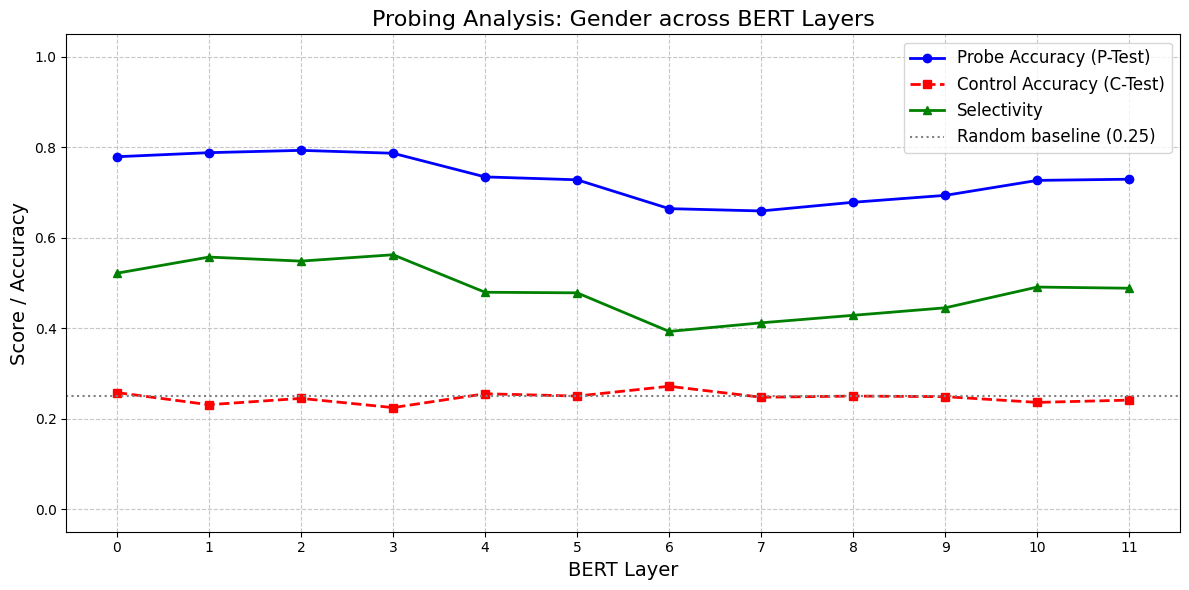

In [37]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Data Preparation
data = {
    'Layer': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    'P_Test': [ 0.7793, 0.7883, 0.7934, 0.7870, 0.7347, 0.7283, 0.6645, 0.6594, 0.6786, 0.6939, 0.7270, 0.7296],
    'C_Test': [0.2577, 0.2309, 0.2449, 0.2245, 0.2551, 0.2500, 0.2717, 0.2474, 0.2500, 0.2487, 0.2360, 0.2411],
    'Selectivity': [ 0.5217, 0.5574, 0.5485, 0.5625, 0.4796, 0.4783, 0.3929, 0.4120, 0.4286, 0.4452, 0.4911, 0.4885]
}
df = pd.DataFrame(data)

# 2. Plotting
plt.figure(figsize=(12, 6))

# Probe Test Accuracy (Original Signal)
plt.plot(df['Layer'], df['P_Test'], marker='o', label='Probe Accuracy (P-Test)', color='blue', linewidth=2)

# Control Test Accuracy (Post-Intervention Signal)
plt.plot(df['Layer'], df['C_Test'], marker='s', label='Control Accuracy (C-Test)', color='red', linestyle='--', linewidth=2)

# Selectivity (Targeted Info Gap)
plt.plot(df['Layer'], df['Selectivity'], marker='^', label='Selectivity', color='green', linewidth=2)

# Chance Level line (Assumed 0.25 for 4 groups or balanced baseline)
plt.axhline(0.25, color='gray', linestyle=':', label='Random baseline (0.25)')

plt.title('Probing Analysis: Gender across BERT Layers', fontsize=16)
plt.xlabel('BERT Layer', fontsize=14)
plt.ylabel('Score / Accuracy', fontsize=14)
plt.xticks(df['Layer'])
plt.ylim(-0.05, 1.05)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12, loc='best')

plt.tight_layout()
plt.savefig('gender_probing_analysis.png')

In [11]:
# --- CONFIGURATION & EXECUTION FOR RELIGION AND RACE ---

# 1. DEFINE LABEL MAPS
religion_label_map = {'christian': 0, 'jewish': 1, 'muslim': 2, 'none': 3}

# 2. PROCESS RELIGION
print("\n" + "#"*30)
print("STAGE 1: RELIGION ANALYSIS")
print("#"*30)

for split in ['train', 'val', 'test']:
    extract_and_store_features(
        model, tokenizer, split, 
        category="religion", 
        label_map=religion_label_map, 
        device=device
    )

religion_extended_stats = perform_probing(category="religion")




##############################
STAGE 1: RELIGION ANALYSIS
##############################

--- Processing probe_religion_train.csv ---


Extracting train:   0%|          | 0/154 [00:00<?, ?it/s]

Saved 13 layers + labels for train.
Using Fixed Label Map: {'christian': 0, 'jewish': 1, 'muslim': 2, 'none': 3}

--- Processing probe_religion_val.csv ---


Extracting val:   0%|          | 0/39 [00:00<?, ?it/s]

Saved 13 layers + labels for val.
Using Fixed Label Map: {'christian': 0, 'jewish': 1, 'muslim': 2, 'none': 3}

--- Processing probe_religion_test.csv ---


Extracting test:   0%|          | 0/12 [00:00<?, ?it/s]

Saved 13 layers + labels for test.
Using Fixed Label Map: {'christian': 0, 'jewish': 1, 'muslim': 2, 'none': 3}

PROBING : RELIGION
L  | P-Iter | C-Iter | P-Train | P-Val   | P-Test  | C-Test  | Selectivity
----------------------------------------------------------------------------------------------------------------------------------
0  | 0      | 0      | 0.2500  | 0.2500  | 0.2500  | 0.2500  | 0.0000
1  | 420    | 801    | 0.9258  | 0.7891  | 0.7826  | 0.2636  | 0.5190
2  | 311    | 565    | 0.9878  | 0.8404  | 0.8152  | 0.2609  | 0.5543
3  | 198    | 535    | 0.9990  | 0.8950  | 0.8913  | 0.2527  | 0.6386
4  | 236    | 492    | 0.9990  | 0.8819  | 0.8859  | 0.2473  | 0.6386
5  | 263    | 442    | 0.9980  | 0.8396  | 0.8614  | 0.2310  | 0.6304
6  | 313    | 350    | 0.9927  | 0.7883  | 0.8207  | 0.2527  | 0.5679
7  | 343    | 295    | 0.9639  | 0.7337  | 0.7337  | 0.2690  | 0.4647
8  | 409    | 366    | 0.9081  | 0.6694  | 0.6766  | 0.2745  | 0.4022
9  | 458    | 357    | 0.8710  |

In [12]:
race_label_map = {'black': 0, 'white': 1, 'none': 2}

# 3. PROCESS RACE
print("\n" + "#"*30)
print("STAGE 2: RACE ANALYSIS")
print("#"*30)

for split in ['train', 'val', 'test']:
    extract_and_store_features(
        model, tokenizer, split, 
        category="race", 
        label_map=race_label_map, 
        device=device
    )

race_extended_stats = perform_probing(category="race")


##############################
STAGE 2: RACE ANALYSIS
##############################

--- Processing probe_race_train.csv ---


Extracting train:   0%|          | 0/494 [00:00<?, ?it/s]

Saved 13 layers + labels for train.
Using Fixed Label Map: {'black': 0, 'white': 1, 'none': 2}

--- Processing probe_race_val.csv ---


Extracting val:   0%|          | 0/124 [00:00<?, ?it/s]

Saved 13 layers + labels for val.
Using Fixed Label Map: {'black': 0, 'white': 1, 'none': 2}

--- Processing probe_race_test.csv ---


Extracting test:   0%|          | 0/35 [00:00<?, ?it/s]

Saved 13 layers + labels for test.
Using Fixed Label Map: {'black': 0, 'white': 1, 'none': 2}

PROBING : RACE
L  | P-Iter | C-Iter | P-Train | P-Val   | P-Test  | C-Test  | Selectivity
----------------------------------------------------------------------------------------------------------------------------------
0  | 0      | 0      | 0.3333  | 0.3335  | 0.3333  | 0.3333  | 0.0000
1  | 627    | 925    | 0.8846  | 0.8376  | 0.8415  | 0.3370  | 0.5046
2  | 443    | 431    | 0.9329  | 0.8922  | 0.8980  | 0.3588  | 0.5392
3  | 423    | 458    | 0.9551  | 0.9130  | 0.9098  | 0.3424  | 0.5674
4  | 445    | 388    | 0.9495  | 0.9008  | 0.9153  | 0.3352  | 0.5801
5  | 398    | 346    | 0.9345  | 0.8877  | 0.8707  | 0.3370  | 0.5337
6  | 361    | 277    | 0.8943  | 0.8558  | 0.8370  | 0.3525  | 0.4845
7  | 273    | 214    | 0.8549  | 0.8140  | 0.7951  | 0.3361  | 0.4590
8  | 312    | 234    | 0.8440  | 0.8047  | 0.7978  | 0.3352  | 0.4627
9  | 304    | 257    | 0.8364  | 0.7882  | 0.7878  | 0

# Section 3: Amnesic Probing with INLP

In [12]:

# 1. CORE INLP MATH 


def get_rowspace_projection(W: np.ndarray) -> np.ndarray:
    """
    Computes the projection matrix onto the rowspace of W.
    """
    if np.allclose(W, 0):
        return np.zeros_like(W.T @ W) 
    w_basis = scipy.linalg.orth(W.T) 
    P_W = w_basis.dot(w_basis.T) 
    return P_W

def get_projection_to_intersection_of_nullspaces(rowspace_projections, input_dim):
    """
    Stable calculation of the intersection of all nullspaces found so far.
    Formula: P = I - Proj(Sum of Rowspace Projections)
    """
    I = np.eye(input_dim)
    if not rowspace_projections:
        return I
    Q = np.sum(rowspace_projections, axis=0)
    P = I - get_rowspace_projection(Q)
    return P

# ==============================================================================
# 2. ROBUST PIPELINE (With Early Stopping)
# ==============================================================================

def train_inlp_for_layer(X_train, Y_train, X_val, Y_val, num_iters=30, min_acc_tol=0.01):
    """
    Runs INLP. Stops early if probe accuracy drops to random chance.
    """
    input_dim = X_train.shape[1]
    num_classes = len(np.unique(Y_train))
    random_baseline = 1.0 / num_classes # e.g., 0.25 for 4 classes
    
    # Threshold: If Acc < Baseline + Tolerance, we stop.
    stop_threshold = random_baseline + min_acc_tol
    
    X_train_cp = X_train.copy()
    X_val_cp = X_val.copy()
    
    rowspace_projections = []
    accuracy_history = []
    
    pbar = tqdm(range(num_iters), desc="INLP Iterations", leave=False)
    
    final_P = np.eye(input_dim)
    
    for i in pbar:
        # 1. Train Probe
        clf = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='auto', random_state=42)
        clf.fit(X_train_cp, Y_train)
        
        # 2. Check Accuracy
        val_acc = clf.score(X_val_cp, Y_val)
        accuracy_history.append(val_acc)
        
        pbar.set_description(f"Iter {i}: Acc {val_acc:.3f} (Base: {random_baseline:.2f})")
        
        # 3. Early Stopping 
        if val_acc < stop_threshold:
            print(f"    Stopping early at iter {i}: Accuracy {val_acc:.3f} is near random ({random_baseline:.2f})")
            break
            
        # 4. Calculate Nullspace
        W = clf.coef_
        P_row = get_rowspace_projection(W)
        rowspace_projections.append(P_row)
        
        # 5. Update Global Projection
        final_P = get_projection_to_intersection_of_nullspaces(rowspace_projections, input_dim)
        
        # 6. Project Data for next iteration
        X_train_cp = X_train.dot(final_P)
        X_val_cp = X_val.dot(final_P)
        
    return final_P, accuracy_history

def run_amnesic_pipeline(category="gender", layers_to_process=range(13)):
    """
    Main runner. Loads your specific .npy files, calculates P, saves P.
    """
    save_dir = f"projections_{category}"
    os.makedirs(save_dir, exist_ok=True)
    
    # Load Labels
    try:
        y_train = np.load(f"feat_{category}_train_labels.npy")
        y_val = np.load(f"feat_{category}_val_labels.npy")
    except FileNotFoundError:
        print(f"Error: Could not find labels for {category}. ?")
        return

    print(f"--- Starting Amnesic Pipeline for {category.upper()} ---")
    
    for layer in layers_to_process:
        print(f"\nProcessing Layer {layer}...")
        
        # Load Features
        try:
            X_train = np.load(f"feat_{category}_train_layer{layer}.npy")
            X_val = np.load(f"feat_{category}_val_layer{layer}.npy")
        except FileNotFoundError:
            print(f"Skipping Layer {layer}: Features not found.")
            continue
            
        # Run INLP
        P, acc_hist = train_inlp_for_layer(X_train, y_train, X_val, y_val)
        
        # Save Projection
        np.save(f"{save_dir}/P_layer{layer}.npy", P)
        
        print(f"  > Initial Acc: {acc_hist[0]:.3f} -> Final Acc: {acc_hist[-1]:.3f}")
        print(f"  > Saved: {save_dir}/P_layer{layer}.npy")

run_amnesic_pipeline(category="gender")
#run_amnesic_pipeline(category="religion")
#run_amnesic_pipeline(category="race")

--- Starting Amnesic Pipeline for GENDER ---

Processing Layer 0...


INLP Iterations:   0%|          | 0/30 [00:00<?, ?it/s]

    Stopping early at iter 0: Accuracy 0.250 is near random (0.25)
  > Initial Acc: 0.250 -> Final Acc: 0.250
  > Saved: projections_gender/P_layer0.npy

Processing Layer 1...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


INLP Iterations:   0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

    Stopping early at iter 25: Accuracy 0.253 is near random (0.25)
  > Initial Acc: 0.710 -> Final Acc: 0.253
  > Saved: projections_gender/P_layer1.npy

Processing Layer 2...


INLP Iterations:   0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

  > Initial Acc: 0.778 -> Final Acc: 0.298
  > Saved: projections_gender/P_layer2.npy

Processing Layer 3...


INLP Iterations:   0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

  > Initial Acc: 0.799 -> Final Acc: 0.411
  > Saved: projections_gender/P_layer3.npy

Processing Layer 4...


INLP Iterations:   0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

  > Initial Acc: 0.794 -> Final Acc: 0.384
  > Saved: projections_gender/P_layer4.npy

Processing Layer 5...


INLP Iterations:   0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

  > Initial Acc: 0.752 -> Final Acc: 0.393
  > Saved: projections_gender/P_layer5.npy

Processing Layer 6...


INLP Iterations:   0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

  > Initial Acc: 0.710 -> Final Acc: 0.390
  > Saved: projections_gender/P_layer6.npy

Processing Layer 7...


INLP Iterations:   0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

  > Initial Acc: 0.684 -> Final Acc: 0.360
  > Saved: projections_gender/P_layer7.npy

Processing Layer 8...


INLP Iterations:   0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

  > Initial Acc: 0.654 -> Final Acc: 0.351
  > Saved: projections_gender/P_layer8.npy

Processing Layer 9...


INLP Iterations:   0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

  > Initial Acc: 0.669 -> Final Acc: 0.378
  > Saved: projections_gender/P_layer9.npy

Processing Layer 10...


INLP Iterations:   0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

  > Initial Acc: 0.678 -> Final Acc: 0.414
  > Saved: projections_gender/P_layer10.npy

Processing Layer 11...


INLP Iterations:   0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

  > Initial Acc: 0.699 -> Final Acc: 0.423
  > Saved: projections_gender/P_layer11.npy

Processing Layer 12...


INLP Iterations:   0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

  > Initial Acc: 0.718 -> Final Acc: 0.447
  > Saved: projections_gender/P_layer12.npy


In [13]:

# 1. METRIC CALCULATION

def get_tpr_fpr(y_true, y_pred):
    """Calculates TPR and FPR with division-by-zero protection."""
    if len(np.unique(y_true)) < 2: 
        return 0.0, 0.0
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    return tpr, fpr

def compute_metrics(df, preds_col, label_col, group_col, target_groups):
    """Computes Global metrics + Max-Min Disparity robustly."""
    y_true = df[label_col].values
    y_prob = df[preds_col].values
    y_pred = (y_prob >= 0.5).astype(int)
    
    stats = {
        'Global AUC': 0.5, 
        'Global TPR': 0.0,
        'Global FPR': 0.0
    }
    
    #  AUC Calculation
    if len(np.unique(y_true)) > 1:
        stats['Global AUC'] = roc_auc_score(y_true, y_prob)
    
    stats['Global TPR'], stats['Global FPR'] = get_tpr_fpr(y_true, y_pred)
    
    # Group Disparities
    tprs, fprs = [], []
    valid_groups = [g for g in target_groups if g in df[group_col].unique()]
    
    for group in valid_groups:
        mask = df[group_col] == group
        if mask.sum() > 0:
            t, f = get_tpr_fpr(y_true[mask], y_pred[mask])
            tprs.append(t)
            fprs.append(f)
            
    if tprs:
        stats['TPR Disparity'] = max(tprs) - min(tprs)
        stats['FPR Disparity'] = max(fprs) - min(fprs)
    else:
        stats['TPR Disparity'] = 0.0
        stats['FPR Disparity'] = 0.0
        
    return stats

# ==============================================================================
# 2. AMNESIC HOOK
# ==============================================================================

class AmnesicHook:
    def __init__(self, P, device):
        # Ensure tensor is Float32 and on correct device immediately
        self.P = torch.tensor(P, dtype=torch.float32, device=device)
    
    def __call__(self, module, input, output):
        # BERT encoder output is a tuple (hidden_states, attention_weights, ...)
        # We need to modify the first element: hidden_states
        if isinstance(output, tuple):
            h_new = torch.matmul(output[0], self.P)
            return (h_new,) + output[1:]
        else:
            return torch.matmul(output, self.P)

# ==============================================================================
# 3. MAIN EVALUATION 
# ==============================================================================

def run_evaluation(category, target_groups):
    print(f"\nProcessing Category: {category.upper()}...")
    
    # 1. Load Test Data
    test_path = f"probe_{category}_test.csv"
    if not os.path.exists(test_path):
        print(f"Skipping {category}: {test_path} not found.")
        return None
    
    df = pd.read_csv(test_path)
    
    # 2. Setup Loader (Assumes tokenizer and JigsawDataset exist globally)
    dataset = JigsawDataset(df['comment_text'].values, tokenizer)
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    
    # 3. Define Inference Function
    def infer():
        model.eval()
        probs = []
        with torch.no_grad():
            for batch in loader:
                ids = batch['ids'].to(device)
                mask = batch['mask'].to(device)
                out = model(ids, attention_mask=mask)
                probs.extend(torch.sigmoid(out.logits).cpu().numpy().flatten())
        return np.array(probs)

    results = []
    
    # --- PHASE 1: BASELINE (No Hooks) ---
    print("  Computing Baseline...")
    df['probs'] = infer()
    base_metrics = compute_metrics(df, 'probs', 'is_toxic', 'probe_label', target_groups)
    base_metrics['Layer'] = 'Baseline'
    results.append(base_metrics)
    
    # --- PHASE 2: APPLYING AMNESIC OPERATION WITH PROJECTION LAYERS ON BERT LAYERS 0-11 ---
    num_encoder_layers = 12 
    
    for layer_idx in tqdm(range(num_encoder_layers), desc=f"Lobotomizing {category}", leave=False):
        
        # ALIGNMENT LOGIC:
        # P_layer0 = Embeddings
        # P_layer1 = Encoder 0 Output
        # ...
        # P_layer12 = Encoder 11 Output
        # When we hook 'model.bert.encoder.layer[0]', we are modifying Encoder 0 Output.
        
        proj_idx = layer_idx + 1
        p_path = f"projections_{category}/P_layer{proj_idx}.npy"
        
        if not os.path.exists(p_path):
            continue
            
        # Load Projection Matrix
        try:
            P = np.load(p_path)
        except Exception as e:
            print(f"Error loading {p_path}: {e}")
            continue

        # Register Hook
        hook = AmnesicHook(P, device)
        handle = model.bert.encoder.layer[layer_idx].register_forward_hook(hook)
        
        try:
            # Run Inference with Hook Active
            df['probs'] = infer()
            m = compute_metrics(df, 'probs', 'is_toxic', 'probe_label', target_groups)
            m['Layer'] = layer_idx # Reporting as Encoder Layer Index
            results.append(m)
        except Exception as e:
            print(f"Error during inference on layer {layer_idx}: {e}")
        finally:
            handle.remove()
            
    return pd.DataFrame(results)

# 4. MAIN EXECUTION

configs = {
    'gender': ['male', 'female', 'homosexual_gay_or_lesbian'],
}

final_tables = {}

for cat, groups in configs.items():
    res = run_evaluation(cat, groups)
    if res is not None:
        cols = ['Layer', 'Global AUC', 'TPR Disparity', 'FPR Disparity', 'Global TPR', 'Global FPR']
        final_tables[cat] = res[cols]

# --- PRINT FINAL TABLES ---
print("\n" + "="*80)
print("FINAL AMNESIC PROBING RESULTS")
print("="*80)

for cat, table in final_tables.items():
    print(f"\nTable: {cat.upper()} Analysis")
    print("-" * 60)
    print(table.to_string(index=False))
    print("-" * 60)


Processing Category: GENDER...
  Computing Baseline...


Lobotomizing gender:   0%|          | 0/12 [00:00<?, ?it/s]


FINAL AMNESIC PROBING RESULTS

Table: GENDER Analysis
------------------------------------------------------------
   Layer  Global AUC  TPR Disparity  FPR Disparity  Global TPR  Global FPR
Baseline    0.915738       0.173469       0.112245    0.645408    0.058673
       0    0.905873       0.173469       0.102041    0.647959    0.079082
       1    0.913766       0.193878       0.030612    0.599490    0.038265
       2    0.914723       0.193878       0.071429    0.653061    0.053571
       3    0.911814       0.132653       0.000000    0.591837    0.035714
       4    0.912797       0.112245       0.040816    0.556122    0.033163
       5    0.913838       0.153061       0.071429    0.591837    0.040816
       6    0.911710       0.153061       0.061224    0.607143    0.035714
       7    0.907467       0.102041       0.051020    0.586735    0.038265
       8    0.906680       0.142857       0.051020    0.602041    0.033163
       9    0.906738       0.112245       0.051020    0.604

In [ ]:
# ==============================================================================
# SELECTIVITY CONTROL 
# ==============================================================================

import numpy as np
import os
import torch
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (roc_auc_score, accuracy_score, f1_score, 
                             precision_score, recall_score)
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

# ------------------------------------------------------------------------------
# 1. SETUP & UTILS
# ------------------------------------------------------------------------------
def compute_all_metrics(y_true, y_probs, prefix=""):
    """Helper to calculate all 5 metrics at once"""
    y_pred = (y_probs >= 0.5).astype(int)
    return {
        f"{prefix}AUC": roc_auc_score(y_true, y_probs),
        f"{prefix}Acc": accuracy_score(y_true, y_pred),
        f"{prefix}F1": f1_score(y_true, y_pred),
        f"{prefix}Prec": precision_score(y_true, y_pred, zero_division=0),
        f"{prefix}Rec": recall_score(y_true, y_pred)
    }

# Map your variables
train_df = g_train
test_df = g_test

# Create Aligned Loaders (Shuffle=False)
train_extract_loader = DataLoader(JigsawDataset(train_df['comment_text'].values, tokenizer), 
                                  batch_size=32, shuffle=False)
test_extract_loader  = DataLoader(JigsawDataset(test_df['comment_text'].values, tokenizer), 
                                  batch_size=32, shuffle=False)

def extract_features_aligned(model, loader, device):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for batch in tqdm(loader, leave=False, desc="Extracting"):
            ids, mask = batch['ids'].to(device), batch['mask'].to(device)
            out = model(ids, attention_mask=mask, output_hidden_states=True)
            rep = out.pooler_output if hasattr(out, 'pooler_output') else out.hidden_states[-1][:, 0, :]
            embeddings.append(rep.cpu().numpy())
    return np.vstack(embeddings)

# ------------------------------------------------------------------------------
# 2. MAIN EXECUTION PIPELINE
# ------------------------------------------------------------------------------
def run_full_proper_analysis(category):
    print(f"\n" + "="*80)
    print(f"FULL SELECTIVITY ANALYSIS: {category.upper()}")
    print("="*80)
    
    y_train, y_test = train_df['is_toxic'].values, test_df['is_toxic'].values
    
    # Setup OneHot
    try: enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    except TypeError: enc = OneHotEncoder(sparse=False, handle_unknown='ignore')
    
    p_train_oh = enc.fit_transform(train_df['probe_label'].values.reshape(-1, 1))
    p_test_oh = enc.transform(test_df['probe_label'].values.reshape(-1, 1))

    results = []

    # --- STEP 1: VANILLA BASELINE (No Intervention) ---
    print("Step 1: Computing Vanilla Baseline...", end=" ")
    X_tr_base = extract_features_aligned(model, train_extract_loader, device)
    X_te_base = extract_features_aligned(model, test_extract_loader, device)
    
    clf_base = LogisticRegression(solver='liblinear', max_iter=1000).fit(X_tr_base, y_train)
    base_metrics = compute_all_metrics(y_test, clf_base.predict_proba(X_te_base)[:, 1], prefix="Base_")
    print(f"DONE. (Baseline AUC: {base_metrics['Base_AUC']:.4f})")

    # --- STEP 2: LAYER-WISE AMNESIC VS SELECTIVITY ---
    for layer_idx in range(12):
        p_path = f"projections_{category}/P_layer{layer_idx + 1}.npy"
        if not os.path.exists(p_path): continue
            
        print(f"Layer {layer_idx:2d}: Processing Intervention...", end=" ")
        P = np.load(p_path)
        hook = AmnesicHook(P, device)
        handle = model.bert.encoder.layer[layer_idx].register_forward_hook(hook)
        
        try:
            # Extract Amnesic features
            X_tr = extract_features_aligned(model, train_extract_loader, device)
            X_te = extract_features_aligned(model, test_extract_loader, device)
            
            # 1. Amnesic Metrics
            clf_amn = LogisticRegression(solver='liblinear', max_iter=1000).fit(X_tr, y_train)
            amn_m = compute_all_metrics(y_test, clf_amn.predict_proba(X_te)[:, 1], prefix="Amn_")
            
            # 2. Selectivity Metrics (Add Gender Back)
            X_tr_sel, X_te_sel = np.hstack([X_tr, p_train_oh]), np.hstack([X_te, p_test_oh])
            clf_sel = LogisticRegression(solver='liblinear', max_iter=1000).fit(X_tr_sel, y_train)
            sel_m = compute_all_metrics(y_test, clf_sel.predict_proba(X_te_sel)[:, 1], prefix="Sel_")
            
            # Combine all
            row = {"Layer": layer_idx}
            row.update(base_metrics)
            row.update(amn_m)
            row.update(sel_m)
            results.append(row)
            print(f"DONE. Delta AUC: {(sel_m['Sel_AUC'] - amn_m['Amn_AUC']):.4f}")
            
        finally: handle.remove()
            
    return pd.DataFrame(results)

# RUN IT
final_analysis_df = run_full_proper_analysis('gender')

# Display useful columns for comparison
cols_to_show = ['Layer', 'Base_AUC', 'Amn_AUC', 'Sel_AUC', 'Base_F1', 'Amn_F1', 'Sel_F1']
print("\nFinal Summary Table (AUC & F1):")
print(final_analysis_df[cols_to_show].to_string(index=False))


FULL SELECTIVITY ANALYSIS: GENDER
Step 1: Computing Vanilla Baseline... 

Extracting:   0%|          | 0/444 [00:00<?, ?it/s]

Extracting:   0%|          | 0/25 [00:00<?, ?it/s]

DONE. (Baseline AUC: 0.9067)
Layer  0: Processing Intervention... 

Extracting:   0%|          | 0/444 [00:00<?, ?it/s]

Extracting:   0%|          | 0/25 [00:00<?, ?it/s]

DONE. Delta AUC: 0.0012
Layer  1: Processing Intervention... 

Extracting:   0%|          | 0/444 [00:00<?, ?it/s]

Extracting:   0%|          | 0/25 [00:00<?, ?it/s]

DONE. Delta AUC: 0.0014
Layer  2: Processing Intervention... 

Extracting:   0%|          | 0/444 [00:00<?, ?it/s]

Extracting:   0%|          | 0/25 [00:00<?, ?it/s]

DONE. Delta AUC: 0.0015
Layer  3: Processing Intervention... 

Extracting:   0%|          | 0/444 [00:00<?, ?it/s]

Extracting:   0%|          | 0/25 [00:00<?, ?it/s]

DONE. Delta AUC: 0.0011
Layer  4: Processing Intervention... 

Extracting:   0%|          | 0/444 [00:00<?, ?it/s]

Extracting:   0%|          | 0/25 [00:00<?, ?it/s]

DONE. Delta AUC: 0.0011
Layer  5: Processing Intervention... 

Extracting:   0%|          | 0/444 [00:00<?, ?it/s]

Extracting:   0%|          | 0/25 [00:00<?, ?it/s]

DONE. Delta AUC: 0.0025
Layer  6: Processing Intervention... 

Extracting:   0%|          | 0/444 [00:00<?, ?it/s]

Extracting:   0%|          | 0/25 [00:00<?, ?it/s]

DONE. Delta AUC: -0.0001
Layer  7: Processing Intervention... 

Extracting:   0%|          | 0/444 [00:00<?, ?it/s]

Extracting:   0%|          | 0/25 [00:00<?, ?it/s]

DONE. Delta AUC: 0.0015
Layer  8: Processing Intervention... 

Extracting:   0%|          | 0/444 [00:00<?, ?it/s]

Extracting:   0%|          | 0/25 [00:00<?, ?it/s]

DONE. Delta AUC: 0.0023
Layer  9: Processing Intervention... 

Extracting:   0%|          | 0/444 [00:00<?, ?it/s]

Extracting:   0%|          | 0/25 [00:00<?, ?it/s]

DONE. Delta AUC: 0.0021
Layer 10: Processing Intervention... 

Extracting:   0%|          | 0/444 [00:00<?, ?it/s]

Extracting:   0%|          | 0/25 [00:00<?, ?it/s]

DONE. Delta AUC: 0.0014
Layer 11: Processing Intervention... 

Extracting:   0%|          | 0/444 [00:00<?, ?it/s]

Extracting:   0%|          | 0/25 [00:00<?, ?it/s]

DONE. Delta AUC: 0.0027

Final Summary Table (AUC & F1):
 Layer  Base_AUC  Amn_AUC  Sel_AUC  Base_F1   Amn_F1   Sel_F1
     0  0.906738 0.901831 0.902996 0.812332 0.794702 0.798949
     1  0.906738 0.905131 0.906569 0.812332 0.795181 0.794157
     2  0.906738 0.912192 0.913708 0.812332 0.802153 0.797333
     3  0.906738 0.904532 0.905612 0.812332 0.806452 0.806924
     4  0.906738 0.908879 0.909953 0.812332 0.807537 0.802139
     5  0.906738 0.907376 0.909881 0.812332 0.809140 0.809079
     6  0.906738 0.907545 0.907415 0.812332 0.800000 0.798398
     7  0.906738 0.906588 0.908085 0.812332 0.818061 0.819149
     8  0.906738 0.905554 0.907844 0.812332 0.821477 0.816489
     9  0.906738 0.908424 0.910558 0.812332 0.810160 0.800532
    10  0.906738 0.908254 0.909693 0.812332 0.809651 0.802139
    11  0.906738 0.907272 0.909959 0.812332 0.809140 0.809587


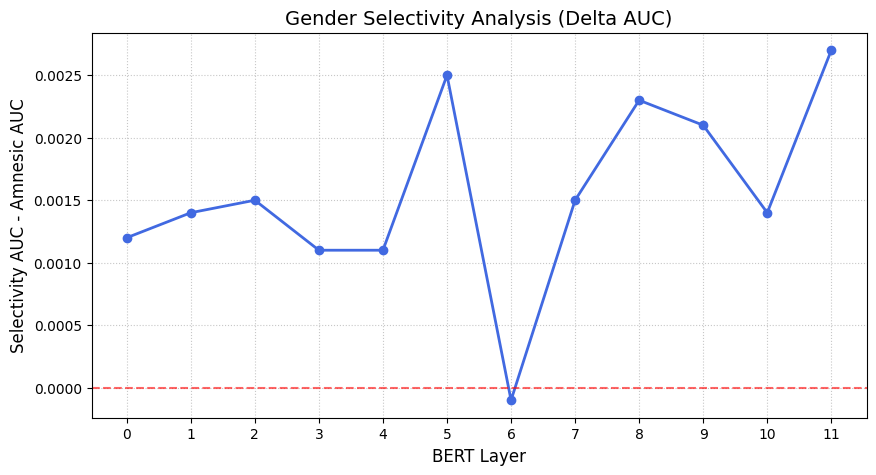

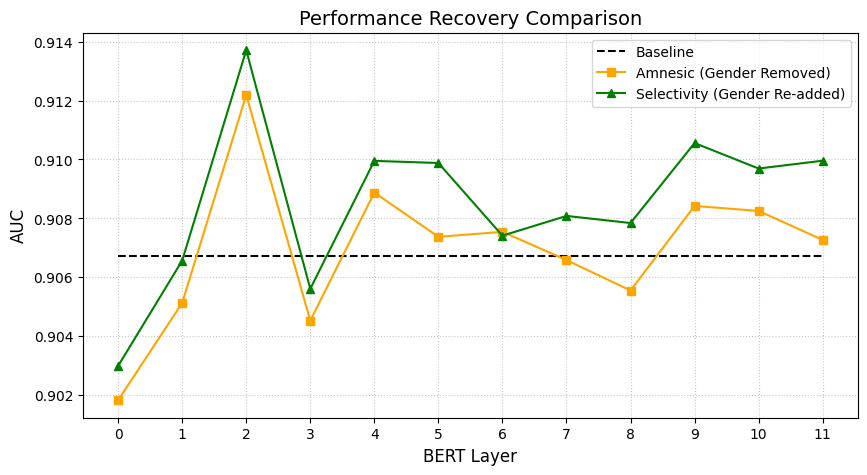

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Data Preparation
layers = list(range(12))
data = {
    'Layer': layers,
    'Base_AUC': [0.906738] * 12,
    'Amn_AUC': [0.901831, 0.905131, 0.912192, 0.904532, 0.908879, 
                0.907376, 0.907545, 0.906588, 0.905554, 0.908424, 
                0.908254, 0.907272],
    'Sel_AUC': [0.902996, 0.906569, 0.913708, 0.905612, 0.909953, 
                0.909881, 0.907415, 0.908085, 0.907844, 0.910558, 
                0.909693, 0.909959],
    'Delta_AUC': [0.0012, 0.0014, 0.0015, 0.0011, 0.0011, 0.0025, 
                  -0.0001, 0.0015, 0.0023, 0.0021, 0.0014, 0.0027]
}
df = pd.DataFrame(data)

# 2. Plotting Delta AUC (Selectivity Proof)
plt.figure(figsize=(10, 5))
plt.plot(df['Layer'], df['Delta_AUC'], marker='o', linestyle='-', color='royalblue', linewidth=2)
plt.axhline(0, color='red', linestyle='--', alpha=0.6)
plt.title('Gender Selectivity Analysis (Delta AUC)', fontsize=14)
plt.xlabel('BERT Layer', fontsize=12)
plt.ylabel('Selectivity AUC - Amnesic AUC', fontsize=12)
plt.xticks(layers)
plt.grid(True, linestyle=':', alpha=0.7)
plt.savefig('selectivity_analysis_delta.png')

# 3. Plotting AUC Comparison
plt.figure(figsize=(10, 5))
plt.plot(df['Layer'], df['Base_AUC'], label='Baseline', color='black', linestyle='--')
plt.plot(df['Layer'], df['Amn_AUC'], label='Amnesic (Gender Removed)', marker='s', color='orange')
plt.plot(df['Layer'], df['Sel_AUC'], label='Selectivity (Gender Re-added)', marker='^', color='green')
plt.title('Performance Recovery Comparison', fontsize=14)
plt.xlabel('BERT Layer', fontsize=12)
plt.ylabel('AUC', fontsize=12)
plt.xticks(layers)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.savefig('auc_comparison.png')

In [21]:
print("done")

done


In [23]:
import numpy as np
import torch
import pandas as pd
import os
from tqdm.auto import tqdm

# ==============================================================================
# 1. RANDOM PROJECTION GENERATOR
# ==============================================================================

def get_random_projection_matching_rank(P_amnesic):
    """
    Analyzes the rank of the amnesic matrix P and creates a random 
    projection matrix that removes the exact same number of dimensions.
    """
    dim = P_amnesic.shape[0]
    # Calculate rank of P to see how many dimensions are LEFT [cite: 91]
    rank_p = np.linalg.matrix_rank(P_amnesic)
    # k is the number of directions REMOVED [cite: 91]
    k = dim - rank_p
    
    if k <= 0:
        return np.eye(dim), 0
    
    # Generate k random directions [cite: 94]
    random_vectors = np.random.normal(0, 1, (k, dim))
    # Find orthogonal basis for the random subspace to remove [cite: 95]
    q, r = np.linalg.qr(random_vectors.T)
    # Projection Matrix = I - QQ^T [cite: 95]
    Q = q[:, :k]
    P_rand = np.eye(dim) - Q @ Q.T
    
    return P_rand, k

In [ ]:
# ==============================================================================
# RAND CONTROL 
# ==============================================================================

def run_rand_evaluation_with_baseline(category, target_groups):
    print(f"\n" + "="*60)
    print(f"RAND CONTROL PIPELINE: {category.upper()}")
    print("="*60)
    
    
    input_base = "/kaggle/working"
    test_path = os.path.join(input_base, f"probe_{category}_test.csv")
    proj_dir = os.path.join(input_base, f"projections_{category}")
    
    if not os.path.exists(test_path):
        raise FileNotFoundError(f"Missing test CSV: {test_path}")
        
    df = pd.read_csv(test_path)
    dataset = JigsawDataset(df['comment_text'].values, tokenizer)
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    
    def infer():
        model.eval()
        probs = []
        with torch.no_grad():
            for batch in loader:
                ids = batch['ids'].to(device)
                mask = batch['mask'].to(device)
                out = model(ids, attention_mask=mask)
                
                if hasattr(out, 'logits'):
                    logits = out.logits
                else:
                    logits = out[0]
                    
                probs.extend(torch.sigmoid(logits).cpu().numpy().flatten())
        return np.array(probs)

    results = []

    # --- STEP 1: BASELINE ---
    print(f"Step 1: Baseline...", end=" ", flush=True)
    df['probs'] = infer()
    base_m = compute_metrics(df, 'probs', 'is_toxic', 'probe_label', target_groups)
    base_m['Layer'] = 'Baseline'
    results.append(base_m)
    print(f"DONE (AUC: {base_m['Global AUC']:.4f})")

    # --- STEP 2: LAYER LOOP ---
    print(f"\nStep 2: Random Intervention...")
    
    # We check 0-11 for the encoder layers
    for layer_idx in range(12):
        # Based on your files: P_layer1 corresponds to Encoder 0 Output
        proj_idx = layer_idx + 1 
        p_path = os.path.join(proj_dir, f"P_layer{proj_idx}.npy")
        
        if not os.path.exists(p_path):
            continue
            
        # Load real matrix to steal its rank (k)
        P_real = np.load(p_path)
        
        # This function must generate a random matrix with the same rank as P_real
        P_rand, k_removed = get_random_projection_matching_rank(P_real)

        # Hook the random matrix into the layer
        hook = AmnesicHook(P_rand, device)
        handle = model.bert.encoder.layer[layer_idx].register_forward_hook(hook)
        
        try:
            print(f"L{layer_idx} (k={k_removed}):", end=" ", flush=True)
            df['probs'] = infer()
            m = compute_metrics(df, 'probs', 'is_toxic', 'probe_label', target_groups)
            m['Layer'] = layer_idx
            results.append(m)
            print(f"AUC: {m['Global AUC']:.4f} | FPR Disp: {m['FPR Disparity']:.4f}")
        except Exception as e:
            print(f"ERR: {e}")
        finally:
            handle.remove() 
            
    return pd.DataFrame(results)

configs = {'gender': ['male', 'female', 'homosexual_gay_or_lesbian']}
res_df = run_rand_evaluation_with_baseline('gender', configs['gender'])
print(res_df[['Layer', 'Global AUC', 'TPR Disparity', 'FPR Disparity']])


RAND CONTROL PIPELINE: GENDER
Step 1: Baseline... DONE (AUC: 0.9157)

Step 2: Random Intervention...
L0 (k=88): AUC: 0.9148 | FPR Disp: 0.0612
L1 (k=106): AUC: 0.9117 | FPR Disp: 0.1224
L2 (k=101): AUC: 0.9133 | FPR Disp: 0.0612
L3 (k=102): AUC: 0.9135 | FPR Disp: 0.0714
L4 (k=101): AUC: 0.9160 | FPR Disp: 0.0714
L5 (k=104): AUC: 0.9139 | FPR Disp: 0.0612
L6 (k=107): AUC: 0.9162 | FPR Disp: 0.0306
L7 (k=105): AUC: 0.9137 | FPR Disp: 0.0714
L8 (k=104): AUC: 0.9153 | FPR Disp: 0.0510
L9 (k=101): AUC: 0.9178 | FPR Disp: 0.0510
L10 (k=100): AUC: 0.9160 | FPR Disp: 0.0714
L11 (k=91): AUC: 0.9158 | FPR Disp: 0.1122
       Layer  Global AUC  TPR Disparity  FPR Disparity
0   Baseline    0.915738       0.173469       0.112245
1          0    0.914821       0.163265       0.061224
2          1    0.911658       0.102041       0.122449
3          2    0.913343       0.122449       0.061224
4          3    0.913474       0.122449       0.071429
5          4    0.915966       0.122449       0.0714

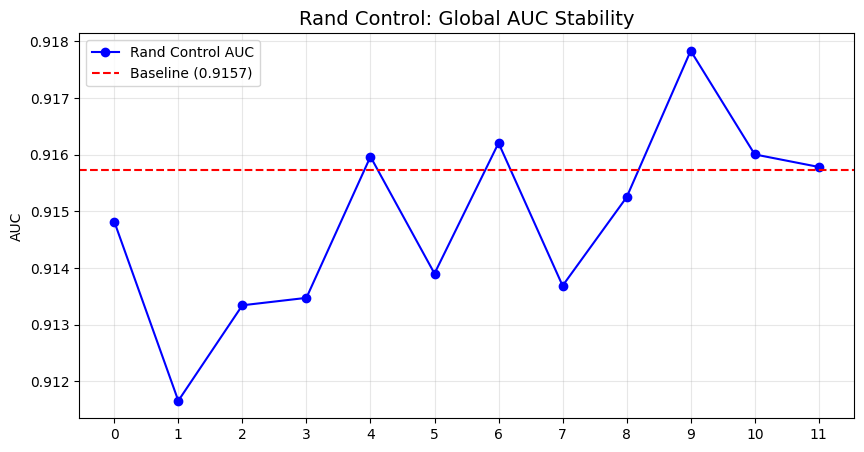

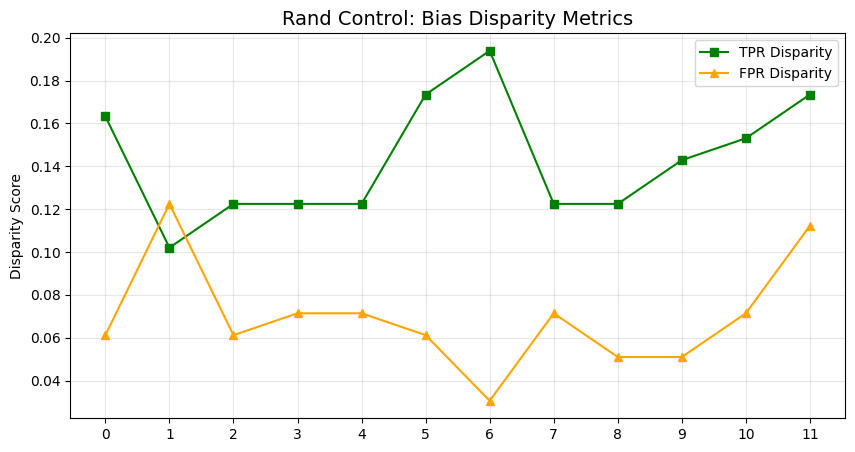

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

# Data from your results
data = {
    'Layer': ['Baseline', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    'Global AUC': [0.915738, 0.914821, 0.911658, 0.913343, 0.913474, 0.915966, 0.913903, 0.916207, 0.913688, 0.915250, 0.917834, 0.916005, 0.915784],
    'TPR Disparity': [0.173469, 0.163265, 0.102041, 0.122449, 0.122449, 0.122449, 0.173469, 0.193878, 0.122449, 0.122449, 0.142857, 0.153061, 0.173469],
    'FPR Disparity': [0.112245, 0.061224, 0.122449, 0.061224, 0.071429, 0.071429, 0.061224, 0.030612, 0.071429, 0.051020, 0.051020, 0.071429, 0.112245]
}
df = pd.DataFrame(data)

# Setup plotting
layers = list(range(12))
auc_vals = df.loc[df['Layer'] != 'Baseline', 'Global AUC']
tpr_vals = df.loc[df['Layer'] != 'Baseline', 'TPR Disparity']
fpr_vals = df.loc[df['Layer'] != 'Baseline', 'FPR Disparity']
base_auc = df.loc[df['Layer'] == 'Baseline', 'Global AUC'].values[0]

# Plot 1: AUC Stability
plt.figure(figsize=(10, 5))
plt.plot(layers, auc_vals, marker='o', label='Rand Control AUC', color='blue')
plt.axhline(y=base_auc, color='red', linestyle='--', label=f'Baseline ({base_auc:.4f})')
plt.title('Rand Control: Global AUC Stability', fontsize=14)
plt.ylabel('AUC')
plt.xticks(layers)
plt.grid(True, alpha=0.3)
plt.legend()
plt.savefig('rand_control_auc.png')

# Plot 2: Disparity Fluctuation
plt.figure(figsize=(10, 5))
plt.plot(layers, tpr_vals, marker='s', label='TPR Disparity', color='green')
plt.plot(layers, fpr_vals, marker='^', label='FPR Disparity', color='orange')
plt.title('Rand Control: Bias Disparity Metrics', fontsize=14)
plt.ylabel('Disparity Score')
plt.xticks(layers)
plt.grid(True, alpha=0.3)
plt.legend()
plt.savefig('rand_control_disparity.png')

In [ ]:
import numpy as np
import torch
import pandas as pd
import os
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

# ==============================================================================
# FINAL CORRECTED  EVALUATION (Amnesic vs Rand vs Selectivity)
# ==============================================================================

def run_complete_master_evaluation(category, target_groups, train_df, test_df):
    print(f"\n" + "="*85)
    print(f"MASTER EVALUATION: {category.upper()} (AMNESIC vs RAND vs SELECTIVITY)")
    print("="*85)

    # 1. Setup Paths and Data
    input_base = "/kaggle/working"
    proj_dir = os.path.join(input_base, f"projections_{category}")
    
    # Loaders for toxicity inference
    test_dataset = JigsawDataset(test_df['comment_text'].values, tokenizer)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # Loaders for feature extraction (Selectivity training)
    train_ext_loader = DataLoader(JigsawDataset(train_df['comment_text'].values, tokenizer), batch_size=32, shuffle=False)
    test_ext_loader = DataLoader(JigsawDataset(test_df['comment_text'].values, tokenizer), batch_size=32, shuffle=False)

    def get_predictions():
        model.eval()
        probs = []
        with torch.no_grad():
            for batch in test_loader:
                ids, mask = batch['ids'].to(device), batch['mask'].to(device)
                out = model(ids, attention_mask=mask)
                logits = out.logits if hasattr(out, 'logits') else out[0]
                probs.extend(torch.sigmoid(logits).cpu().numpy().flatten())
        return np.array(probs)

    results = []

    # --- STEP 1: BASELINE ---
    print("Step 1: Baseline Inference...", end=" ", flush=True)
    test_df['probs'] = get_predictions()
    base_m = compute_metrics(test_df, 'probs', 'is_toxic', 'probe_label', target_groups)
    print(f"DONE (AUC: {base_m['Global AUC']:.4f})")

    # --- STEP 2: LAYER-BY-LAYER ANALYSIS ---
    for layer_idx in range(12):
        proj_idx = layer_idx + 1 # Matches your P_layer1.npy...P_layer12.npy
        p_path = os.path.join(proj_dir, f"P_layer{proj_idx}.npy")
        if not os.path.exists(p_path): continue
        
        print(f"Layer {layer_idx:2d}: Running Experiments...", end=" ", flush=True)
        P_real = np.load(p_path)

        # A. AMNESIC INTERVENTION (Targeted)
        hook_amn = AmnesicHook(P_real, device)
        handle_amn = model.bert.encoder.layer[layer_idx].register_forward_hook(hook_amn)
        
        amn_probs = get_predictions()
        m_amn = compute_metrics(test_df.copy().assign(probs=amn_probs), 'probs', 'is_toxic', 'probe_label', target_groups)
        
        # B. SELECTIVITY RECOVERY (Extraction + Re-adding Labels)
        # Extract features while the Amnesic hook is active
        X_train_amn = extract_features_aligned(model, train_ext_loader, device)
        X_test_amn = extract_features_aligned(model, test_ext_loader, device)
        handle_amn.remove() # Remove hook for next test

        # FIX: One-Hot Encoding for the 'male'/'female' strings
        enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        z_train_oh = enc.fit_transform(train_df['probe_label'].values.reshape(-1, 1))
        z_test_oh = enc.transform(test_df['probe_label'].values.reshape(-1, 1))
        
        # Stack numerical BERT embeddings with numerical One-Hot vectors
        X_train_sel = np.hstack([X_train_amn, z_train_oh])
        X_test_sel = np.hstack([X_test_amn, z_test_oh])

        # Train a toxicity classifier on the "Restored" features
        clf_sel = LogisticRegression(solver='liblinear', max_iter=500)
        clf_sel.fit(X_train_sel, train_df['is_toxic'].values)
        sel_probs = clf_sel.predict_proba(X_test_sel)[:, 1]
        sel_auc = roc_auc_score(test_df['is_toxic'].values, sel_probs)

        # C. RAND CONTROL (Random Matching Rank)
        P_rand, k_removed = get_random_projection_matching_rank(P_real)
        hook_rand = AmnesicHook(P_rand, device)
        handle_rand = model.bert.encoder.layer[layer_idx].register_forward_hook(hook_rand)
        
        rand_probs = get_predictions()
        m_rand = compute_metrics(test_df.copy().assign(probs=rand_probs), 'probs', 'is_toxic', 'probe_label', target_groups)
        handle_rand.remove()

        results.append({
            'Layer': layer_idx,
            'Base_AUC': base_m['Global AUC'],
            'Amn_AUC': m_amn['Global AUC'],
            'Sel_AUC': sel_auc,
            'Rand_AUC': m_rand['Global AUC'],
            'Amn_FPR_Disp': m_amn['FPR Disparity'],
            'Rand_FPR_Disp': m_rand['FPR Disparity']
        })
        print(f"DONE (k={k_removed}).")

    return pd.DataFrame(results)

# --- EXECUTION ---
# Using your global train_df and test_df
target_identity_groups = ['male', 'female', 'homosexual_gay_or_lesbian']
master_table = run_complete_master_evaluation('gender', target_identity_groups, train_df, test_df)

print("\n" + "="*85)
print("FINAL CONSOLIDATED RESULTS")
print("="*85)
print(master_table.to_string(index=False))


MASTER EVALUATION: GENDER (AMNESIC vs RAND vs SELECTIVITY)
Step 1: Baseline Inference... DONE (AUC: 0.9157)
Layer  0: Running Experiments... 

Extracting:   0%|          | 0/444 [00:00<?, ?it/s]

Extracting:   0%|          | 0/25 [00:00<?, ?it/s]

DONE (k=88).
Layer  1: Running Experiments... 

Extracting:   0%|          | 0/444 [00:00<?, ?it/s]

Extracting:   0%|          | 0/25 [00:00<?, ?it/s]

DONE (k=106).
Layer  2: Running Experiments... 

Extracting:   0%|          | 0/444 [00:00<?, ?it/s]

Extracting:   0%|          | 0/25 [00:00<?, ?it/s]

DONE (k=101).
Layer  3: Running Experiments... 

Extracting:   0%|          | 0/444 [00:00<?, ?it/s]

Extracting:   0%|          | 0/25 [00:00<?, ?it/s]

DONE (k=102).
Layer  4: Running Experiments... 

Extracting:   0%|          | 0/444 [00:00<?, ?it/s]

Extracting:   0%|          | 0/25 [00:00<?, ?it/s]

DONE (k=101).
Layer  5: Running Experiments... 

Extracting:   0%|          | 0/444 [00:00<?, ?it/s]

Extracting:   0%|          | 0/25 [00:00<?, ?it/s]

DONE (k=104).
Layer  6: Running Experiments... 

Extracting:   0%|          | 0/444 [00:00<?, ?it/s]

Extracting:   0%|          | 0/25 [00:00<?, ?it/s]

DONE (k=107).
Layer  7: Running Experiments... 

Extracting:   0%|          | 0/444 [00:00<?, ?it/s]

Extracting:   0%|          | 0/25 [00:00<?, ?it/s]

DONE (k=105).
Layer  8: Running Experiments... 

Extracting:   0%|          | 0/444 [00:00<?, ?it/s]

Extracting:   0%|          | 0/25 [00:00<?, ?it/s]

DONE (k=104).
Layer  9: Running Experiments... 

Extracting:   0%|          | 0/444 [00:00<?, ?it/s]

Extracting:   0%|          | 0/25 [00:00<?, ?it/s]

DONE (k=101).
Layer 10: Running Experiments... 

Extracting:   0%|          | 0/444 [00:00<?, ?it/s]

Extracting:   0%|          | 0/25 [00:00<?, ?it/s]

DONE (k=100).
Layer 11: Running Experiments... 

Extracting:   0%|          | 0/444 [00:00<?, ?it/s]

Extracting:   0%|          | 0/25 [00:00<?, ?it/s]

DONE (k=91).

FINAL CONSOLIDATED RESULTS
 Layer  Base_AUC  Amn_AUC  Sel_AUC  Rand_AUC  Amn_FPR_Disp  Rand_FPR_Disp
     0  0.915738 0.905873 0.902996  0.913975      0.102041       0.061224
     1  0.915738 0.913766 0.906569  0.914743      0.030612       0.091837
     2  0.915738 0.914723 0.913708  0.913252      0.071429       0.091837
     3  0.915738 0.911814 0.905612  0.914918      0.000000       0.112245
     4  0.915738 0.912797 0.909953  0.914092      0.040816       0.061224
     5  0.915738 0.913838 0.909881  0.916083      0.071429       0.102041
     6  0.915738 0.911710 0.907415  0.912771      0.061224       0.071429
     7  0.915738 0.907467 0.908085  0.916792      0.051020       0.030612
     8  0.915738 0.906680 0.907844  0.916012      0.051020       0.081633
     9  0.915738 0.906738 0.910558  0.916636      0.051020       0.071429
    10  0.915738 0.914606 0.909693  0.914808      0.071429       0.102041
    11  0.915738 0.915244 0.909959  0.914294      0.112245       0.1122

Master comparison graph saved as: master_auc_comparison.png


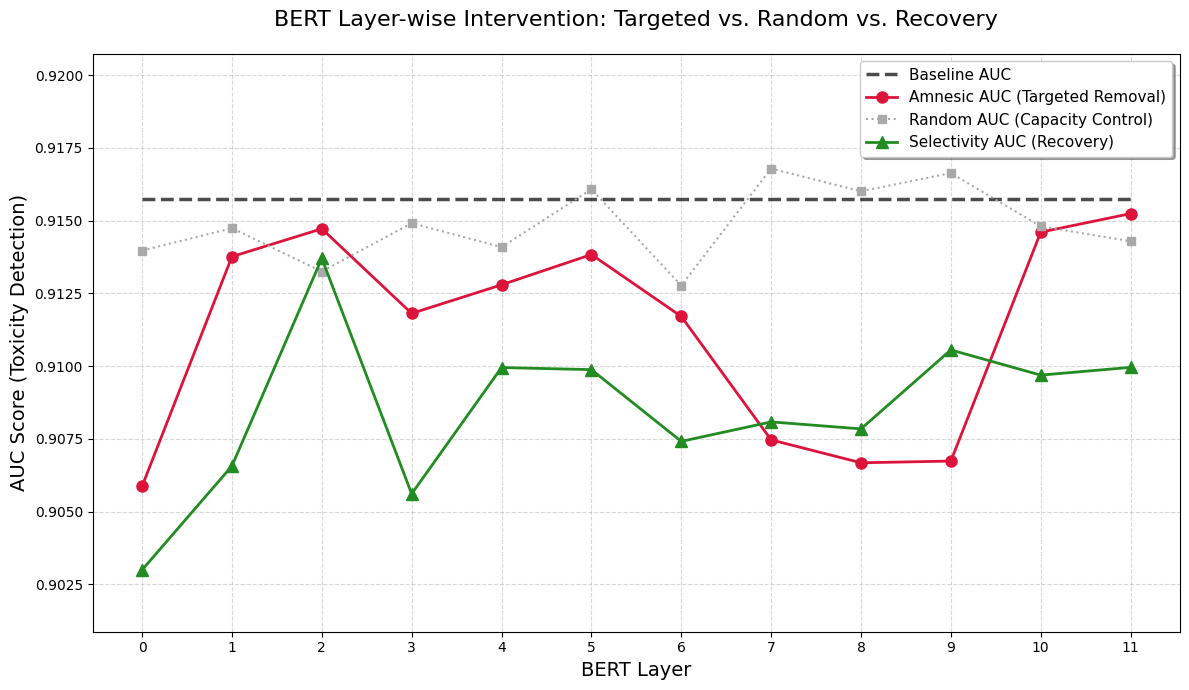

In [ ]:
import matplotlib.pyplot as plt

def plot_master_auc_results(df):
    plt.figure(figsize=(12, 7))
    
    # 1. Baseline: The "untouched" performance
    plt.plot(df['Layer'], df['Base_AUC'], label='Baseline AUC', 
             color='black', linestyle='--', linewidth=2.5, alpha=0.7)
    
    # 2. Amnesic: Performance after targeted gender removal
    plt.plot(df['Layer'], df['Amn_AUC'], label='Amnesic AUC (Targeted Removal)', 
             marker='o', color='crimson', linewidth=2, markersize=8)
    
    # 3. Random Control: Performance after removing random noise
    plt.plot(df['Layer'], df['Rand_AUC'], label='Random AUC (Capacity Control)', 
             marker='s', color='darkgray', linestyle=':', linewidth=1.5, markersize=6)
    
    # 4. Selectivity: Performance after manually restoring gender labels
    plt.plot(df['Layer'], df['Sel_AUC'], label='Selectivity AUC (Recovery)', 
             marker='^', color='forestgreen', linewidth=2, markersize=8)
    
    plt.title('BERT Layer-wise Intervention: Targeted vs. Random vs. Recovery', fontsize=16, pad=20)
    plt.xlabel('BERT Layer', fontsize=14)
    plt.ylabel('AUC Score (Toxicity Detection)', fontsize=14)
    plt.xticks(df['Layer'])
    
    y_min = min(df['Amn_AUC'].min(), df['Rand_AUC'].min()) - 0.005
    y_max = max(df['Sel_AUC'].max(), df['Base_AUC'].max()) + 0.005
    plt.ylim(y_min, y_max)
    
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(fontsize=11, loc='best', frameon=True, shadow=True)
    
    plt.tight_layout()
    plt.savefig('master_auc_comparison.png')
    print("Master comparison graph saved as: master_auc_comparison.png")

plot_master_auc_results(master_table)

Fairness graph saved as: bias_mitigation_comparison.png


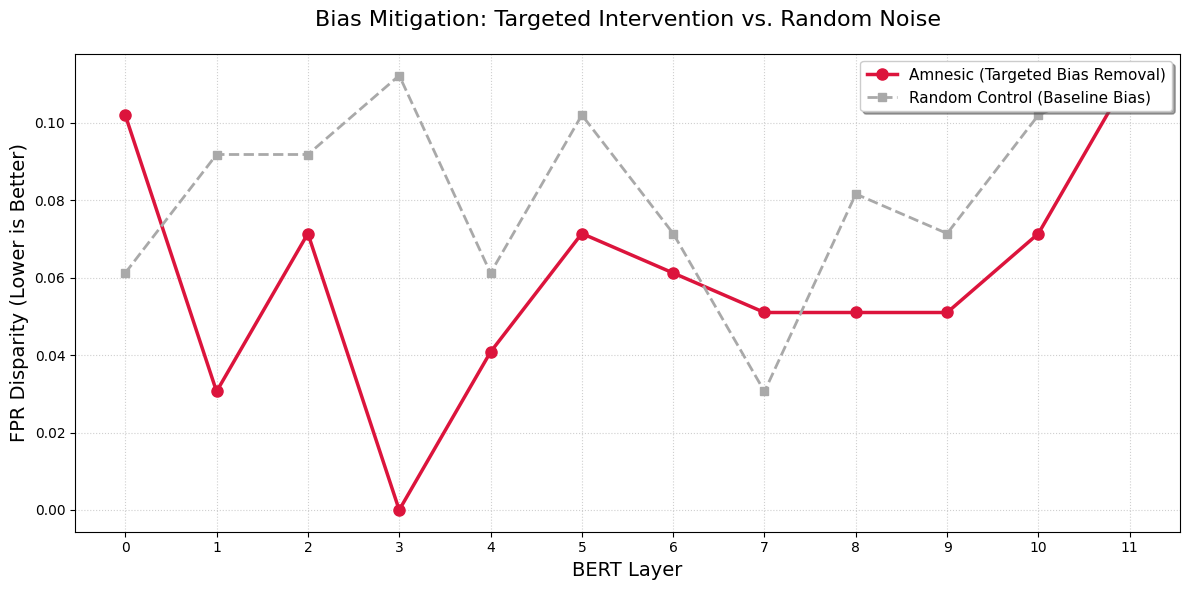

In [ ]:
import matplotlib.pyplot as plt

def plot_fairness_comparison(df):
    plt.figure(figsize=(12, 6))
    
    # 1. Amnesic Bias: The target of our intervention
    plt.plot(df['Layer'], df['Amn_FPR_Disp'], label='Amnesic (Targeted Bias Removal)', 
             marker='o', color='crimson', linewidth=2.5, markersize=8)
    
    # 2. Random Bias: What happens if we just remove random directions
    plt.plot(df['Layer'], df['Rand_FPR_Disp'], label='Random Control (Baseline Bias)', 
             marker='s', color='darkgray', linestyle='--', linewidth=2, markersize=6)
    
    plt.title('Bias Mitigation: Targeted Intervention vs. Random Noise', fontsize=16, pad=20)
    plt.xlabel('BERT Layer', fontsize=14)
    plt.ylabel('FPR Disparity (Lower is Better)', fontsize=14)
    plt.xticks(df['Layer'])
    
   
    
    

    plt.grid(True, linestyle=':', alpha=0.6)
    plt.legend(fontsize=11, loc='upper right', frameon=True, shadow=True)
    
    plt.tight_layout()
    plt.savefig('bias_mitigation_comparison.png')
    print("Fairness graph saved as: bias_mitigation_comparison.png")

plot_fairness_comparison(master_table)